In [73]:
import torch
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy

In [72]:
device

device(type='cuda')

In [50]:
model = mobilenet_v2(weights = MobileNet_V2_Weights.DEFAULT)



In [ ]:
model.eval()

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
train_nodes, eval_nodes = get_graph_node_names(mobilenet_v2())
train_nodes

In [53]:
return_nodes = {
    'flatten': 'features',
}
feature_extractor = create_feature_extractor(model, return_nodes=return_nodes)

In [77]:
feature_extractor(torch.randn(1, 3, 64, 64))['features'].shape

torch.Size([1, 1280])

In [96]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [55]:
# Define Transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import itertools
import numpy as np

train_transform = transforms.Compose([
    # Input is 96x96. We RandomCrop to 64x64
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # CenterCrop to 64x64 for testing
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Datasets
# Note: We load the training data twice to apply different transforms to train vs val subsets seamlessly
# or we can rely on Subset. However, Subset inherits the dataset's transform.
# A cleaner way is to create two dataset instances.

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=test_transform)

# Split indices
targets = train_dataset.labels
train_idx, val_idx = train_test_split(
    np.arange(len(train_dataset)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Create Subsets
# To properly handle transforms, we'll create two base datasets with correct transforms

val_base = datasets.STL10(root='./data', split='train', download=True, transform=test_transform)

# Full training datasets for final training
train_ds_aug = train_dataset
train_ds_clean = val_base

train_set = Subset(train_ds_aug, train_idx)
val_set = Subset(train_ds_clean, val_idx)

# Create DataLoader for test evaluation
batch_size = 128 # Increased batch size for more stable gradients
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train Size: {len(train_set)} | Val Size: {len(val_set)} | Test Size: {len(test_dataset)}")

Train Size: 4000 | Val Size: 1000 | Test Size: 8000


In [97]:
class MobileNetFeatureExtractor(nn.Module):
    def __init__(self, extractor, num_classes=10):
        super(MobileNetFeatureExtractor, self).__init__()
        # Create feature extractor using mobile_net_model
        self.feature_extractor = extractor
        # Define fully connected layers
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 218)
        self.classifier = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(0.4),
            self.fc2,
            nn.ReLU(),
            # classification layer
            nn.Linear(218, num_classes)
        )
    def forward(self, x):
        x = self.feature_extractor(x)['features']
        x = self.classifier(x)
        return x

In [98]:

m = MobileNetFeatureExtractor(feature_extractor).to(device)

In [ ]:
m.eval()

In [90]:
full_train_loader = DataLoader(
    train_ds_aug,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

In [119]:
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5
optimizer = optim.Adam(m.parameters(), lr=1e-4, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=50, eta_min=1e-6)

In [120]:
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [121]:
final_epochs = 50
patience = 3
counter = 0
best_val_loss = float('inf')

In [122]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(loader.dataset)
    acc = 100 * correct / total
    return avg_loss, acc

In [123]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {final_epochs} epochs with patience={patience}...")

for epoch in tqdm(range(final_epochs)):
    m.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in full_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(full_train_loader.dataset)
    train_acc = 100 * correct / total
    val_loss, val_acc = evaluate_model(m, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(m.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0 or (epoch + 1) == final_epochs:
        print(
            f"Epoch [{epoch+1}/{final_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )


Starting training for 50 epochs with patience=3...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 0.4151 | Train Acc: 85.64% | Val Loss: 0.4088 | Val Acc: 85.83%
Early stopping triggered at epoch 11


In [124]:
max(val_accs)

86.325

Loaded best model weights with Val Loss: 0.4060


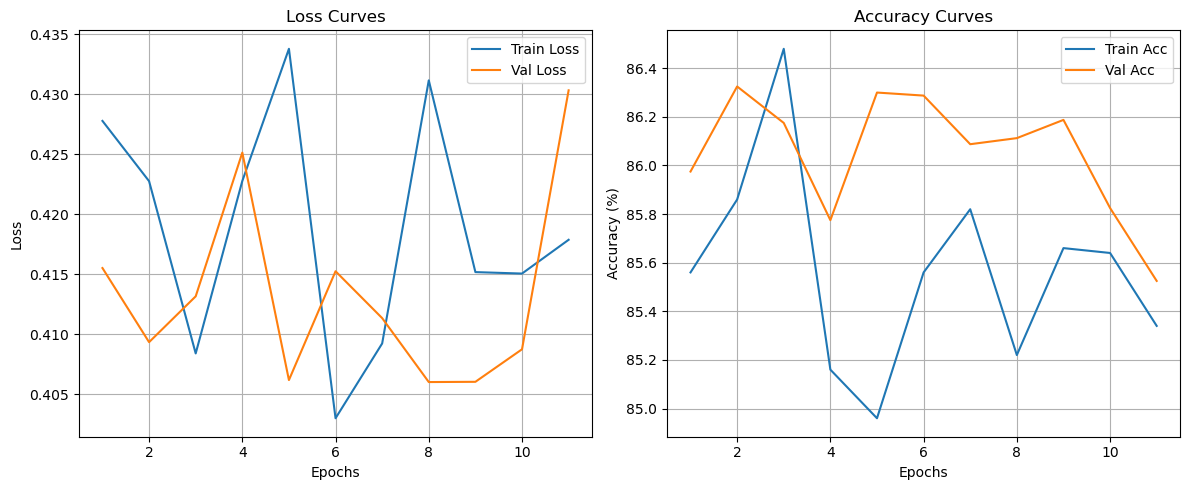

In [125]:
# Load best model weights
import matplotlib.pyplot as plt
m.load_state_dict(best_model_wts)
print(f"Loaded best model weights with Val Loss: {best_val_loss:.4f}")

actual_epochs = len(train_losses)
epochs_range = range(1, actual_epochs + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs_range, train_losses, label='Train Loss')
ax1.plot(epochs_range, val_losses, label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.grid(True)
ax1.legend()

ax2.plot(epochs_range, train_accs, label='Train Acc')
ax2.plot(epochs_range, val_accs, label='Val Acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Curves')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

In [126]:
m.eval()
correct = 0
total = 0

print("Evaluating on Test Set...")
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = m(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Accuracy on the 8000 test images: {100 * correct / total:.2f} %')

Evaluating on Test Set...


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Final Accuracy on the 8000 test images: 86.11 %
